Notebook to plot the histogram of the power criterion values of Rel-UME test.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import freqopttest.tst as tst
import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util, plot, glo, log
from kmod.ex import cifar10 as cf10
import kmod.ex.exutil as exu

from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import autograd.numpy as np
import scipy.stats as stats
import numpy.testing as testing

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# plot.set_default_matplotlib_options()
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 20,
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [13]:
# def store_path(fname):
#     """
#     Construct a full path for saving/loading files.
#     """
#     return os.path.join('cifar10', fname)
display(list(zip(range(10), cf10.cifar10_classes)))


[(0, 'airplane'),
 (1, 'automobile'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]

# Histogram of power criterion values

First construct four samples: X~P, Y~Q, Z~R, and a pool W to be used as test location candidates.

In [193]:
# class_spec = [
#     # (class, #points for p, #points for q, #points for r, #points for the pool)
#     ('airplane', 2000, 0, 0, 1500),
#     ('cat',      0, 2000, 2000, 1500),
#     ('truck',    1500, 1500, 1500, 1500),
    
# ]

# class_spec = [
#     # (class, #points for p, #points for q, #points for r, #points for the pool)
#     ('airplane', 1000, 0, 0, 300),
#     ('cat',      0, 1000, 1000, 300),
#     ('truck',    1500, 1500, 1500, 300),
    
# ]
class_spec = [
     # (class, #points for p, #points for q, #points for r, #points for the pool)
    ('ship', 2000, 0, 0, 1000),
    ('airplane',      0, 2000, 1500, 1000),
    ('dog',    1500, 1500, 1500, 1000), 
    ('bird', 0, 0, 500, 1000),
]
# class_spec = [
#     # (class, #points for p, #points for q, #points for r, #points for the pool)
#     ('horse', 2000, 0, 0, 1000),
#     ('deer',      0, 2000, 1500, 1000),
#     ('dog',    1500, 1500, 1500, 1000),   
#     ('automobile', 0, 0, 500, 1000),
# ]
# class_spec = [
#     # (class, #points for p, #points for q, #points for r, #points for the pool)
#     ('airplane', 2000, 0, 0, 1000),
#     ('automobile',      0, 2000, 1500, 1000),
#     ('cat',    1500, 1500, 1500, 1000),   
#     ('frog', 0, 0, 500, 1000),
# ]
#class_spec = [
    # (class, #points for p, #points for q, #points for r, #points for the pool)
#    ('airplane', 2000, 0, 0, 1000),
#    ('automobile',      0, 2000, 2000, 1000),
#    ('cat',    1500, 1500, 1500, 1000),   
#]

# class_spec = [
#     # (class, #points for p, #points for q, #points for r, #points for the pool)
#     ('airplane', 200, 0, 0, 150),
#     ('cat',      0, 200, 200, 150),
#     ('truck',    150, 150, 150, 150),
    
# ]

In [194]:
# check sizes
hist_classes = [z[0] for z in class_spec]
p_sizes = [z[1] for z in class_spec]
q_sizes = [z[2] for z in class_spec]
r_sizes = [z[3] for z in class_spec]
pool_sizes = [z[4] for z in class_spec]

# make sure p,q,r have the same sample size
assert sum(p_sizes) == sum(q_sizes)
assert sum(q_sizes) == sum(r_sizes)

# cannot use more than 6000 from each class
for i, cs in enumerate(class_spec):
    class_used = sum(cs[1:])
    if class_used > 6000:
        raise ValueError('class "{}" requires more than 6000 points. Was {}.'.format(cs[0], class_used))

In [195]:
# images as numpy arrays
list_Ximgs = []
list_Yimgs = []
list_Zimgs = []
list_poolimgs = []

# features
list_X = []
list_Y = []
list_Z = []
list_pool = []
# class labels
list_Xlabels = []
list_Ylabels = []
list_Zlabels = []
list_poollabels = []

In [196]:
# seed used for subsampling
seed = 368
with util.NumpySeedContext(seed=seed):
    for i, cs in enumerate(class_spec):
        # load class data
        class_i = cs[0]
        imgs_i = cf10.load_data_array(class_i)
        feas_i = cf10.load_feature_array(class_i)

        # split each class according to the spec
        class_sizes_i = cs[1:]
        # imgs_i, feas_i may contain more than what we need in total for a class. Subsample
        sub_ind = util.subsample_ind(imgs_i.shape[0], sum(class_sizes_i), seed=seed+1)
        sub_ind = list(sub_ind)
        assert len(sub_ind) == sum(class_sizes_i)
        
        xyzp_imgs_i = util.multi_way_split(imgs_i[sub_ind,:], class_sizes_i)
        xyzp_feas_i = util.multi_way_split(feas_i[sub_ind,:], class_sizes_i)
        
        # assignment
        list_Ximgs.append(xyzp_imgs_i[0])
        list_Yimgs.append(xyzp_imgs_i[1])
        list_Zimgs.append(xyzp_imgs_i[2])
        list_poolimgs.append(xyzp_imgs_i[3])
        
        list_X.append(xyzp_feas_i[0])
        list_Y.append(xyzp_feas_i[1])
        list_Z.append(xyzp_feas_i[2])
        list_pool.append(xyzp_feas_i[3])
        
        # class labels
        class_ind_i = cf10.cifar10_class_ind_dict[class_i]
        list_Xlabels.append(np.ones(class_sizes_i[0])*class_ind_i)
        list_Ylabels.append(np.ones(class_sizes_i[1])*class_ind_i)
        list_Zlabels.append(np.ones(class_sizes_i[2])*class_ind_i)
        list_poollabels.append(np.ones(class_sizes_i[3])*class_ind_i)

Finally we have the samples (features and images)

In [197]:
# stack the lists. For the "histogram" purpose, we don't actually need
# images for X, Y, Z. Only images for the pool.
Ximgs = np.vstack(list_Ximgs)
Yimgs = np.vstack(list_Yimgs)
Zimgs = np.vstack(list_Zimgs)
poolimgs = np.vstack(list_poolimgs)

# features
X = np.vstack(list_X)
Y = np.vstack(list_Y)
Z = np.vstack(list_Z)
pool = np.vstack(list_pool)

# labels
Xlabels = np.hstack(list_Xlabels)
Ylabels = np.hstack(list_Ylabels)
Zlabels = np.hstack(list_Zlabels)
poollabels = np.hstack(list_poollabels)

In [198]:
# sanity check
XYZP = [(X, Ximgs, Xlabels), (Y, Yimgs, Ylabels), (Z, Zimgs, Zlabels), (pool, poolimgs, poollabels)]
for f, fimgs, flabels in XYZP:
    assert f.shape[0] == fimgs.shape[0]
    assert fimgs.shape[0] == flabels.shape[0]
assert X.shape[0] == sum(p_sizes)
assert Y.shape[0] == sum(q_sizes)
assert Z.shape[0] == sum(r_sizes)
assert pool.shape[0] == sum(pool_sizes)

## The actual histogram

In [199]:
def eval_test_locations(X, Y, Z, loc_pool, k, func_inds, reg=1e-6):
    """
    Use X, Y, Z to estimate the Rel-UME power criterion function and evaluate
    the function at each point (individually) in loc_pool (2d numpy array).
    
    * k: a kernel
    * func_inds: list of indices of the functions to evaluate. See below.
    * reg: regularization parameter in the power criterion
    
    Return an m x (up to) 5 numpy array where m = number of candidates in the
    pool. The columns can be (as specified in func_inds): 
        0. power criterion
        1. evaluation of the relative witness (or the test statistic of UME_SC)
        2. evaluation of MMD witness(p, r) (not squared)
        3. evaluation of witness(q, r)
        4. evaluate of witness(p, q)
        
    """
    datap = data.Data(X)
    dataq = data.Data(Y)
    datar = data.Data(Z)

    powcri_func = mct.SC_UME.get_power_criterion_func(datap, dataq, datar, k, k, reg=1e-7)
    relwit_func = mct.SC_UME.get_relative_sqwitness(datap, dataq, datar, k, k)
    witpr = tst.MMDWitness(k, X, Z)
    witqr = tst.MMDWitness(k, Y, Z)
    witpq = tst.MMDWitness(k, X, Y)
    
    funcs = [powcri_func, relwit_func, witpr, witqr, witpq]
    # select the functions according to func_inds
    list_evals = [funcs[i](loc_pool) for i in func_inds]
    stack_evals = np.vstack(list_evals)
    return stack_evals.T
    

In [200]:
# Gaussian kernel with median heuristic
medxz = util.meddistance(np.vstack((X, Z)), subsample=1000)
medyz = util.meddistance(np.vstack((Y, Z)), subsample=1000)
k = kernel.KGauss(np.mean([medxz, medyz])**2)
print('Gaussian width: {}'.format(k.sigma2**0.5))

Gaussian width: 19.392208099365234


In [201]:
# histogram. This will take some time.
func_inds = np.array([0, 1, 2, 3, 4])
pool_evals = eval_test_locations(X, Y, Z, loc_pool=pool, k=k, func_inds=func_inds, reg=1e-6)

In [202]:
pow_cri_values = pool_evals[:, func_inds==0].reshape(-1)
test_stat_values = pool_evals[:, func_inds==1].reshape(-1)
witpr_values = pool_evals[:, func_inds==2]
witqr_values = pool_evals[:, func_inds==3]
witpq_values = pool_evals[:, func_inds==4].reshape(-1)

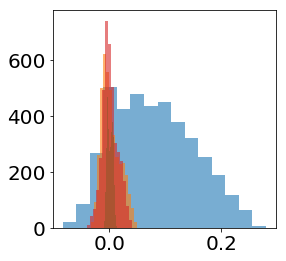

In [203]:
plt.figure(figsize=(6, 4))
a = 0.6
plt.figure(figsize=(4,4))
plt.hist(pow_cri_values, bins=15, label='Power Criterion', alpha=a);
plt.hist(witpr_values, bins=15, label='Power Criterion', alpha=a);
plt.hist(witqr_values, bins=15, label='Power Criterion', alpha=a);
plt.hist(witpq_values, bins=15, label='Power Criterion', alpha=a);

In [204]:
# Save the results
# package things to save
datapack = {
    'class_spec': class_spec,
    'seed': seed,
    'poolimgs': poolimgs,
    'X': X,
    'Y': Y,
    'Z': Z,
    'pool': pool,
    'medxz': medxz,
    'medyz': medyz,
    'func_inds': func_inds,
    'pool_evals': pool_evals,
}


lines = [ '_'.join(str(x) for x in cs)  for cs in class_spec]
fname = '-'.join(lines) + '-seed{}.pkl'.format(seed)
with open(fname, 'wb') as f:
    # expect result to be a dictionary
    pickle.dump(datapack, f)


Code for running the experiment ends here. 

## Plot the results 

This section can be run by loading the previously saved results.

In [205]:
# load the results
# fname = 'airplane_2000_0_0_1000-automobile_0_2000_1500_1000-cat_1500_1500_1500_1000-frog_0_0_500_1000-seed368.pkl'
# fname = 'ship_2000_0_0_1000-airplane_0_2000_1500_1000-automobile_1500_1500_1500_1000-bird_0_0_500_1000-seed368.pkl'
# fname = 'ship_2000_0_0_1000-dog_0_2000_1500_1000-automobile_1500_1500_1500_1000-bird_0_0_500_1000-seed368.pkl'
fname = 'ship_2000_0_0_1000-airplane_0_2000_1500_1000-dog_1500_1500_1500_1000-bird_0_0_500_1000-seed368.pkl'
# fname = 'horse_2000_0_0_1000-deer_0_2000_1500_1000-dog_1500_1500_1500_1000-airplane_0_0_500_1000-seed368.pkl'
# fname = 'horse_2000_0_0_1000-deer_0_2000_1500_1000-dog_1500_1500_1500_1000-automobile_0_0_500_1000-seed368.pkl'
# fname = 'horse_2000_0_0_1000-deer_0_2000_2000_1000-dog_1500_1500_1500_1000-seed368.pkl'
#fname = 'airplane_2000_0_0_1000-automobile_0_2000_2000_1000-cat_1500_1500_1500_1000-seed368.pkl'
with open(fname, 'rb') as f:
    # expect a dictionary
    L = pickle.load(f)

# load the variables
class_spec = L['class_spec']
seed = L['seed']
poolimgs = L['poolimgs']
X = L['X']
Y = L['Y']
Z = L['Z']
pool = L['pool']
medxz = L['medxz']
medyz = L['medyz']
func_inds = L['func_inds']
pool_evals = L['pool_evals']

In [206]:
pow_cri_values = pool_evals[:, func_inds==0].reshape(-1)
test_stat_values = pool_evals[:, func_inds==1].reshape(-1)
witpq_values = pool_evals[:, func_inds==4].reshape(-1)

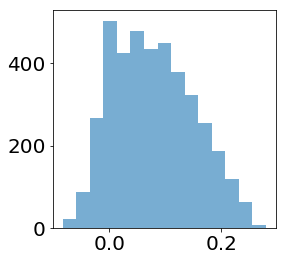

In [207]:
# plot the histogram
plt.figure(figsize=(6, 4))
a = 0.6
plt.figure(figsize=(4,4))
plt.hist(pow_cri_values, bins=15, label='Power Criterion', alpha=a);
# plt.hist(test_stat_values, label='Stat.', alpha=a);
# plt.legend()
plt.savefig('powcri_hist_locs_pool.pdf', bbox_inches='tight')

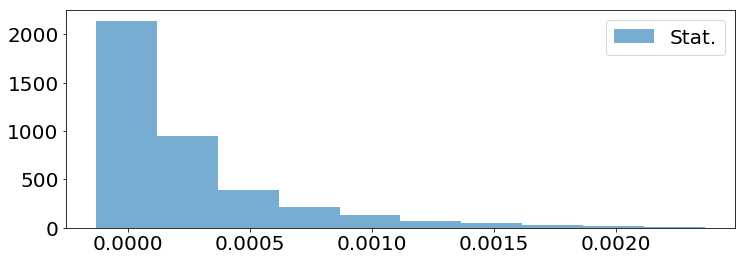

In [208]:
plt.figure(figsize=(12, 4))
plt.hist(test_stat_values, label='Stat.', alpha=a);
plt.legend()

In [209]:
def reshape_3c_rescale(img_in_stack):
    img = img_in_stack.reshape([3, 32, 32])
    # h x w x c
    img = img.transpose([1, 2, 0])/255.0
    return img

def plot_lowzerohigh(images, values, text_in_title='', grid_rows=2,
        grid_cols=10, figsize=(13, 3)):
    """
    Sort the values in three different ways (ascending, descending, absolute ascending).
    Plot the images corresponding to the top-k sorted values. k is determined
    by the grid size.
    """
    low_inds, zeros_inds, high_inds = util.top_lowzerohigh(values)
    
    plt.figure(figsize=figsize)
    exu.plot_images_grid(images[low_inds], reshape_3c_rescale, grid_rows, grid_cols)
#     plt.suptitle('{} Low'.format(text_in_title))
    plt.savefig('powcri_low_region.pdf', bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    exu.plot_images_grid(images[zeros_inds], reshape_3c_rescale, grid_rows, grid_cols)
#     plt.suptitle('{} Near Zero'.format(text_in_title))
    plt.savefig('powcri_zero_region.pdf', bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    exu.plot_images_grid(images[high_inds], reshape_3c_rescale, grid_rows, grid_cols)
#     plt.suptitle('{} High'.format(text_in_title))
    plt.savefig('powcri_high_region.pdf', bbox_inches='tight')


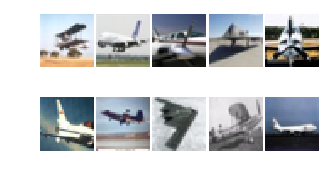

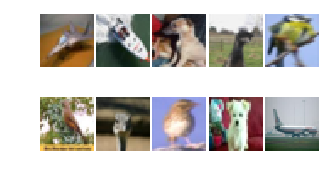

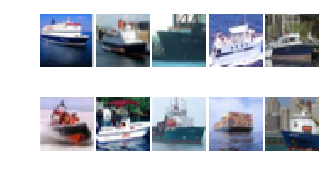

In [210]:
grid_rows = 2
grid_cols = 5
figsize = (5, 3)
plot_lowzerohigh(poolimgs, pow_cri_values, 'Power Criterion.', grid_rows, grid_cols, figsize)

In [211]:
# plot_lowzerohigh(poolimgs, rel_wit_values, 'Test statistic.', grid_rows, grid_cols, figsize)

In [212]:
import matplotlib.gridspec as gridspec

def plot_images_grid_witness(images, func_img=None, grid_rows=4, grid_cols=4, witness_pq=None, scale=100.):
    """
    Plot images in a grid, starting from index 0 to the maximum size of the
    grid. 

    images: stack of images images[i] is one image
    func_img: function to run on each image before plotting
    """
    gs1 = gridspec.GridSpec(grid_rows, grid_cols)
    gs1.update(wspace=0.2, hspace=0.8) # set the spacing between axes. 
    wit_sign = np.sign(witness_pq)

    for i in range(grid_rows*grid_cols):
        if func_img is not None:
            img = func_img(images[i])
        else:
            img = images[i]
        if witness_pq is not None:
            sign = wit_sign[i]
            if sign > 0:
                color = 'red'
            else:
                color = 'blue'
        
#         plt.subplot(grid_rows, grid_cols, i+1)
        ax = plt.subplot(gs1[i])
        if witness_pq is not None:
            ax.text(0.5, -0.6, "{:1.2f}".format(scale*witness_pq[i]), ha="center",
                    color=color, transform=ax.transAxes)
        plt.imshow(img)
        plt.axis('off')

In [216]:
def plot_lowzerohigh(images, values, text_in_title='', grid_rows=2,
        grid_cols=10, figsize=(13, 3), wit_pq=None, skip_length=1):
    """
    Sort the values in three different ways (ascending, descending, absolute ascending).
    Plot the images corresponding to the top-k sorted values. k is determined
    by the grid size.
    """
    low_inds, zeros_inds, high_inds = util.top_lowzerohigh(values)
    
    low_inds = low_inds[::skip_length]
    zeros_inds = zeros_inds[::skip_length]
    high_inds = high_inds[::skip_length]

    plt.figure(figsize=figsize)
    plot_images_grid_witness(images[low_inds], reshape_3c_rescale, grid_rows, grid_cols, wit_pq[low_inds])
    # plt.suptitle('{} Low'.format(text_in_title))
    # plt.savefig('powcri_low_region.pdf', bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    plot_images_grid_witness(images[zeros_inds], reshape_3c_rescale, grid_rows, grid_cols, wit_pq[zeros_inds])
    # plt.suptitle('{} Near Zero'.format(text_in_title))
    # plt.savefig('powcri_zero_region.pdf', bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    plot_images_grid_witness(images[high_inds[:]], reshape_3c_rescale, grid_rows, grid_cols, wit_pq[high_inds])
    # plt.suptitle('{} High'.format(text_in_title))
    # plt.savefig('powcri_high_region.pdf', bbox_inches='tight')

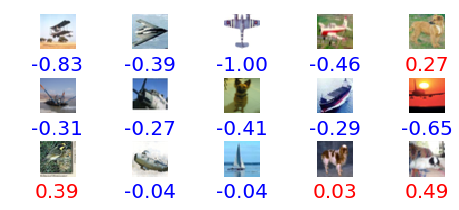

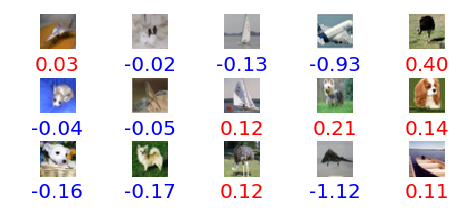

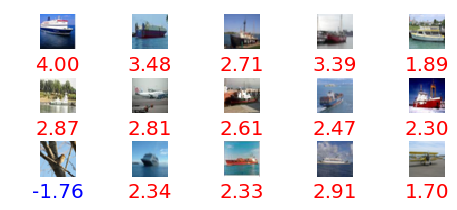

In [224]:
grid_rows = 3
grid_cols = 5
figsize = (8, 3)
plot_lowzerohigh(poolimgs, pow_cri_values, 'Power Criterion.', grid_rows, grid_cols, figsize, witpq_values, skip_length=40)